In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats

In [2]:
# Create a Pandas DataFrame with data for calibration of Torsion pendulum

# The data elements are [mass in mg, error in mass in mg, angle in degrees, error in angle in degrees]
calibration_data = [[0, 0.0, 25.5, 0.5], [20, 0.0, 160,0.5], [40, 0.0, 291,0.5], [50, 0.0, 353.5,0.5], [70, 0.0, 490,0.5], [90, 0.0, 630,0.5]]

# The values in this next line are for the WebWork exercise.
#calibration_data = [[152.9, 0.0, 9.3, 0.0], [448.5, 0.0, 19.3, 0.0], [550.5, 0.0, 25.1, 0.0], [560.7, 0.0, 29.8, 0.0], [825.7, 0.0, 39.1, 0.0]]

# create dataframe
df = pd.DataFrame(calibration_data, columns = ['Mass_mg', 'dMass_mg', 'Theta_Raw', 'dTheta_Raw'])
df

,Mass_mg,dMass_mg,Theta_Raw,dTheta_Raw
0,0,0.0,25.5,0.5
1,20,0.0,160.0,0.5
2,40,0.0,291.0,0.5
3,50,0.0,353.5,0.5
4,70,0.0,490.0,0.5
5,90,0.0,630.0,0.5


In [3]:
# Calcualate the actual value of theta by subtracting off the angle for Mass=0.  Also, calculate the error in the actual
# angle using dTheta = dTheta_Raw[i] + dtheta_Raw[0]

offset = df['Theta_Raw'][0]
doffset = df['dTheta_Raw'][0]

# For WebWork
#offset = 0
#doffset = 0

df['Theta'] = df['Theta_Raw'] - offset
df['dTheta'] = df['dTheta_Raw'] + doffset


# Calculate the mass in kg, and the error in the mass in kg
df['Mass'] = df['Mass_mg']*0.000001
df['dMass'] = df['dMass_mg']*0.000001

# Calculate the gravitational Force (and Error) in Newtons
g = 9.80524
df['Force'] = df['Mass']*g
df['dForce'] = df['dMass']*g

df

,Mass_mg,dMass_mg,Theta_Raw,dTheta_Raw,Theta,dTheta,Mass,dMass,Force,dForce
0,0,0.0,25.5,0.5,0.0,1.0,0.00000,0.0,0.000000,0.0
1,20,0.0,160.0,0.5,134.5,1.0,0.00002,0.0,0.000196,0.0
2,40,0.0,291.0,0.5,265.5,1.0,0.00004,0.0,0.000392,0.0
3,50,0.0,353.5,0.5,328.0,1.0,0.00005,0.0,0.000490,0.0
4,70,0.0,490.0,0.5,464.5,1.0,0.00007,0.0,0.000686,0.0
5,90,0.0,630.0,0.5,604.5,1.0,0.00009,0.0,0.000882,0.0


# Fitting Stuff

We have already seen examples of both linear and non-linear regression fits to data.  In most (maybe all?) experiments though, we often have uncertainties associated with each data point.  We should understand more about how this affects the fitting procedure.

The linear/non-linear regression examples that we have studied thus far use a method called "Ordinary Least Squares".  The basic theory behind this is:

$\chi^2 = \sum_i^N (y_i - y_{fit}(x_i))^2$

where $y_{fit} = f(a,b,c,...)$ is the fitting function.  The idea is that we must solve the set of equations defined by:

$\frac{\partial \chi^2}{\partial a} = 0, \frac{\partial \chi^2}{\partial b} = 0, \frac{\partial \chi^2}{\partial c} = 0, ...$

In the case of polynomial fitting functions (of any order), the values of the polynomial coefficients are uniquely defined.  That is, there is a single global minimum in the $\chi^2$ function.  For other non-linear fitting functions, there may be local minima in the $\chi^2$ function, and this requires that we provide initial starting values for the parameters of the fitting function that are close to the global minimum.

When we have uncertainties for each of the $N$ data points, the definition of $\chi^2$ becomes:

$\chi^2 = \sum_i^N \left (\frac{y_i - y_{fit}(x_i)}{\sigma_i}\right)^2$

Now, for this calibration procedure, we have ZERO uncertainty in the y-variable (Mass), and we have some non-zero uncertainty in the x-variable (Angle).  As it turns out, the Ordinary Least Squares procedure can ONLY take into account uncertainties in the y-variable!!!!  This is a actually a significant limitation of this procedure, and we actually should use a more advanced methodology.  However, what we will do for the moment is to simply ignore the errors, and hope that errors in both x and y are manifested in the scatter of the data points themselves.  This is not a totally crazy idea, and in fact it is done quite a lot in the real world.  But, I just wanted to make the point here that there are other, better ways of handling errors in the data points, and you should be aware of that.

Coefficients (from curve_fit)
[2.04351430e-06 1.46641832e-06]
Covariance Matrix (from curve_fit)
[[ 1.53822504e-11 -3.55593437e-14]
 [-3.55593437e-14  1.18729022e-16]]

Final Result: Force = (0.000001466 +/- 0.000000011) Theta + (0.000002044 +/- 0.000003922)


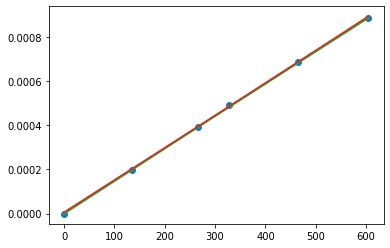

In [4]:
from scipy.optimize import curve_fit

def fitfunction(x,*paramlist):
    return paramlist[0]+paramlist[1]*x

xi = df['Theta']
yi = df['Force']

init_vals = [0.0 for x in range(2)]
popt, pcov = curve_fit(fitfunction,xi,yi,p0=init_vals)
perr = np.sqrt(np.diag(pcov))

ps = np.random.multivariate_normal(popt,pcov,10000)
ysample=np.asarray([fitfunction(xi,*pi) for pi in ps])

lower = np.percentile(ysample,16.0,axis=0)
upper = np.percentile(ysample,84.0,axis=0)
middle = (lower+upper)/2.0

print("Coefficients (from curve_fit)")
print (popt)
print("Covariance Matrix (from curve_fit)")
print (pcov)

print()
print ("Final Result: Force = (%0.9f +/- %0.9f) Theta + (%0.9f +/- %0.9f)" % (popt[1],perr[1],popt[0],perr[0]))

plt.plot(xi,yi,'o')

plt.plot(xi,middle)
plt.plot(xi,lower)
plt.plot(xi,upper)
plt.show()

In [5]:
#
# Remember the results of the calibration part of the experiment ... we will use this later, to convert angles into Force values!
#
calibration_factor = popt[1]
dcalibration_factor = perr[1]

In [6]:
# Create a Pandas DataFrame with data for part 1 of the experiment:  understanding the relation of Force to distance, at constant
# charge

# The data elements are [distance in cm, angle in degrees] ... again, since we are going to do a linear regression using OLS, we will
# not include errors
data1 = [[20,15], [20,16.5], [14,45], [14,41], [10,65], [10,72], [9,80], [9,80], [8,105], [8,103], [7,141], [7,140], [6,181], [6,178]]

# create dataframe
df2 = pd.DataFrame(data1, columns = ['R_cm', 'Theta'])
df2

,R_cm,Theta
0,20,15.0
1,20,16.5
2,14,45.0
3,14,41.0
4,10,65.0
5,10,72.0
6,9,80.0
7,9,80.0
8,8,105.0
9,8,103.0


In [7]:
# The theory tells us that F = k * Q1 * Q2 / R^2.  So, if we were to plot a graph of F vs. 1/R^2, it should be a straight line
# with a slope of (k*Q1*Q2).  Let's try that!

# We will have to convert the angle values to Forces, and also include an uncertainty.

df2['Force'] = df2['Theta']*calibration_factor
df2['dForce'] = df2['Theta']*dcalibration_factor

df2['R'] = df2['R_cm']*0.01

df2

,R_cm,Theta,Force,dForce,R
0,20,15.0,0.000022,1.634443e-07,0.20
1,20,16.5,0.000024,1.797887e-07,0.20
2,14,45.0,0.000066,4.903328e-07,0.14
3,14,41.0,0.000060,4.467477e-07,0.14
4,10,65.0,0.000095,7.082585e-07,0.10
5,10,72.0,0.000106,7.845325e-07,0.10
6,9,80.0,0.000117,8.717028e-07,0.09
7,9,80.0,0.000117,8.717028e-07,0.09
8,8,105.0,0.000154,1.144110e-06,0.08
9,8,103.0,0.000151,1.122317e-06,0.08


Coefficients (from curve_fit)
[-5.45267438e-07  9.96952712e-07]
Covariance Matrix (from curve_fit)
[[ 4.06873274e-12 -5.42873235e-14]
 [-5.42873235e-14  1.37393032e-15]]

Final Result: Force = (0.000000997 +/- 0.000000037) 1/R^2 + (-0.000000545 +/- 0.000002017)


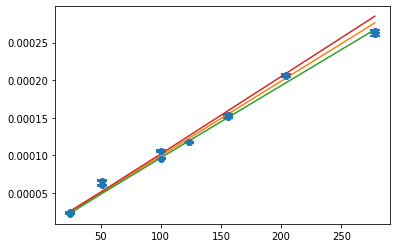

In [8]:
xi = 1.0/(df2['R'])**2
yi = df2['Force']
sigmai = df2['dForce']

plt.errorbar(xi, yi, yerr=sigmai, fmt='o', capsize=5, capthick=2)

init_vals = [0.0 for x in range(2)]
popt, pcov = curve_fit(fitfunction,xi,yi,p0=init_vals,sigma=sigmai)
perr = np.sqrt(np.diag(pcov))

ps = np.random.multivariate_normal(popt,pcov,10000)
ysample=np.asarray([fitfunction(xi,*pi) for pi in ps])

lower = np.percentile(ysample,16.0,axis=0)
upper = np.percentile(ysample,84.0,axis=0)
middle = (lower+upper)/2.0

print("Coefficients (from curve_fit)")
print (popt)
print("Covariance Matrix (from curve_fit)")
print (pcov)

print()
print ("Final Result: Force = (%0.9f +/- %0.9f) 1/R^2 + (%0.9f +/- %0.9f)" % (popt[1],perr[1],popt[0],perr[0]))

plt.plot(xi,middle)
plt.plot(xi,lower)
plt.plot(xi,upper)
plt.show()

In [9]:
#
# Now, let us see if we can calculate what k is, based on the slope from the previous graph
#

slope = popt[1]
dslope = perr[1]

# We know that the slope is supposed to be:  k*Q1*Q2.  So, what are Q1 and Q2?  According to the same theory, they should be
# equal to one another, and be related to the applied voltage, V, according to:
#
#  Q = (R_sphere/k)*V
#
#  Substituting this into our experession for the slope, we get:
#
#  slope = k * (R_sphere/k)V * (R_sphere/k)V = R_sphere^2*V^2/k
#
#  k = R_sphere^2*V^2/slope
#
#  We used V = 6.00 kV = 6000 V
#  We are told that R_sphere = 1.9 cm = 0.019 m
#
#  But, there are uncertainties in both of these numbers:
#
# dV = 10 Volts + 0.01*Voltage = 10 Volts + 0.01*(6000 V) = 70 Volts
# dR_sphere = 0.1 cm = 0.001 m
#
# From basic error analysis, we get that (dk/k) = 2dR_sphere/R_sphere + 2dV/V + dslope/slope

V = 6000
dV = 10 + 0.01*V
R_sphere = 0.019
dR_sphere = 0.001

k = R_sphere**2*V**2/slope
dk = k*(2*dR_sphere/R_sphere+2*dV/V+dslope/slope)

print ('Extracted value of k = (%0.1f +/- %0.1f) x 10^9 Nm^2/C^2' % (k/1E9,dk/1E9))

Extracted value of k = (13.0 +/- 2.2) x 10^9 Nm^2/C^2


In [10]:
# Finally, let's calculate an error budget.  We would like to understand how much the various uncertainties in the experiment
# contribute to the final error that we get in the extraction of k.

error_budget = [['R_sphere',2*dR_sphere/R_sphere*100],['V',2*dV/V*100],['Slope',dslope/slope*100],['Total',dk/k*100]]
df4 = pd.DataFrame(error_budget, columns = ['Source', 'Percentage Error'])
df4

,Source,Percentage Error
0,R_sphere,10.526316
1,V,2.333333
2,Slope,3.717986
3,Total,16.577636


In [11]:
# Create a Pandas DataFrame with data for part 2 of the experiment:  understanding the relation of Force to Charge, at constant
# R

# The data elements are [Voltage in Volts, angle in degrees] ... again, since we are going to do a linear regression using OLS, we will
# not include errors in the angle at this point

data2 = [[6000,97], [6000,100], [5000,75], [5000,78], [4000,62], [4000,65], [3000,40], [3000,44], [2000,25], [2000,23], [1000,10], [1000,11]]

# create dataframe
df3 = pd.DataFrame(data2, columns = ['V', 'Theta'])
df3

,V,Theta
0,6000,97
1,6000,100
2,5000,75
3,5000,78
4,4000,62
5,4000,65
6,3000,40
7,3000,44
8,2000,25
9,2000,23


In [12]:
# The theory tells us that F = k * Q1 * Q2 / R^2 = k * Q^2/R^2.
#
# The theory also tells us that Q = (R_sphere/k) * V
# 
# Thus, we have that F = k * ((R_sphere/k)V)**2/R^2 = k * (R_sphere/R)^2 * 1/k^2 * V^2 = 1/k * (R_sphere/R)^2 * V^2
#
# So, if we plot F vs. V^2, we should get a straight line, with a slope of 1/k*(R_sphere/R)^2.  Let's try that!

# We will have to convert the angle values to Forces, and also include an uncertainty.

df3['Force'] = df3['Theta']*calibration_factor
df3['dForce'] = df3['Theta']*dcalibration_factor

df3['dV'] = 10.0 + 0.01*df3['V']

df3

,V,Theta,Force,dForce,dV
0,6000,97,0.000142,1.056940e-06,70.0
1,6000,100,0.000147,1.089628e-06,70.0
2,5000,75,0.000110,8.172214e-07,60.0
3,5000,78,0.000114,8.499102e-07,60.0
4,4000,62,0.000091,6.755697e-07,50.0
5,4000,65,0.000095,7.082585e-07,50.0
6,3000,40,0.000059,4.358514e-07,40.0
7,3000,44,0.000065,4.794365e-07,40.0
8,2000,25,0.000037,2.724071e-07,30.0
9,2000,23,0.000034,2.506145e-07,30.0


Coefficients (from curve_fit)
[1.25639551e-05 4.30386500e-12]
Covariance Matrix (from curve_fit)
[[ 2.66778837e-12 -2.28684739e-19]
 [-2.28684739e-19  8.24204303e-26]]

Final Result: Force = (0.000000000 +/- 0.000000000) V^2 + (0.000012564 +/- 0.000001633)


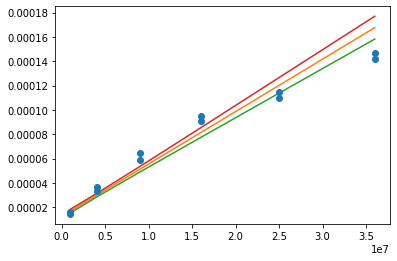

In [13]:
xi = (df3['V'])**2
yi = df3['Force']
sigmai = df3['dForce']
sigmax = df3['dV']

plt.errorbar(xi, yi, xerr=sigmax,yerr=sigmai, fmt='o', capsize=2, capthick=1)

init_vals = [0.0 for x in range(2)]
popt, pcov = curve_fit(fitfunction,xi,yi,p0=init_vals,sigma=sigmai)
perr = np.sqrt(np.diag(pcov))

ps = np.random.multivariate_normal(popt,pcov,10000)
ysample=np.asarray([fitfunction(xi,*pi) for pi in ps])

lower = np.percentile(ysample,16.0,axis=0)
upper = np.percentile(ysample,84.0,axis=0)
middle = (lower+upper)/2.0

print("Coefficients (from curve_fit)")
print (popt)
print("Covariance Matrix (from curve_fit)")
print (pcov)

print()
print ("Final Result: Force = (%0.9f +/- %0.9f) V^2 + (%0.9f +/- %0.9f)" % (popt[1],perr[1],popt[0],perr[0]))

plt.plot(xi,middle)
plt.plot(xi,lower)
plt.plot(xi,upper)
plt.show()

In [14]:
#
# Now, let us see if we can calculate what k is, based on the slope from the previous graph
#

slope = popt[1]
dslope = perr[1]

# We know that the slope is supposed to be:  1/k * (R_sphere/R)^2.
#
#  k = (R_sphere/R)^2/slope
#
# From basic error analysis, we get that (dk/k) = 2dR_sphere/R_sphere + 2dR/R + dslope/slope

R = 0.08
dR = 0.001

k = 1/slope * R_sphere**2/R**2
dk = k*(2*dR/R+2*dR_sphere/R_sphere+dslope/slope)

print ('Extracted value of k = (%0.1f +/- %0.1f) x 10^9 Nm^2/C^2' % (k/1E9,dk/1E9))

Extracted value of k = (13.1 +/- 2.6) x 10^9 Nm^2/C^2


In [15]:
# Finally, let's calculate an error budget.  We would like to understand how much the various uncertainties in the experiment
# contribute to the final error that we get in the extraction of k.

error_budget = [['R_sphere',2*dR_sphere/R_sphere*100],['R',2*dR/R*100],['Slope',dslope/slope*100],['Total',dk/k*100]]
df4 = pd.DataFrame(error_budget, columns = ['Source', 'Percentage Error'])
df4

,Source,Percentage Error
0,R_sphere,10.526316
1,R,2.500000
2,Slope,6.670506
3,Total,19.696822
